## Download dataset and import library

In [8]:
!gdown 1dANzxlEjeCEbveFOWWqzSG-niVx-vCgK

Downloading...
From: https://drive.google.com/uc?id=1dANzxlEjeCEbveFOWWqzSG-niVx-vCgK
To: /content/sentiment_analysis.csv
100% 1.10M/1.10M [00:00<00:00, 73.1MB/s]


In [9]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

## Read dataset

In [10]:
PATH = 'sentiment_analysis.csv'
df = pd.read_csv(PATH, index_col='id')
df.head()

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...


## Preprocessing data

### Build a text normalization function

In [11]:
def text_normalize(text):
  # Retweet old acronym 'RT' removal
  text = re.sub(r'^RT[\s]+', '', text)

  # URL removal
  text = re.sub(r'https?:\/\/.*[\ r\n]*', '', text)

  # Hashtag removal
  text = re.sub(r'#', '', text)

  # Punctuation removal
  text = re.sub(r'[^\w\s]', '', text)

  # Tokenization
  tokenizer = TweetTokenizer(preserve_case=False,
                             strip_handles=True,
                             reduce_len=True)
  text_tokens = tokenizer.tokenize(text)

  return text_tokens

### Build a word frequency

In [12]:
def get_freqs(df):
  freqs = defaultdict(lambda: 0)
  for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']

    tokens = text_normalize(tweet)
    for token in tokens:
      pair = (token, label)
      freqs[pair] += 1

  return freqs

### Build a feature vector function

In [13]:
def get_feature(text, freqs):
  tokens = text_normalize(text)

  X = np.zeros(3)
  X[0] = 1

  for token in tokens:
    X[1] += freqs[(token, 0)]
    X[2] += freqs[(token, 1)]

  return X

### Extract features from data

In [14]:
X = []
y = []

freqs = get_freqs(df)
for idx, row in df.iterrows():
  tweet = row['tweet']
  label = row['label']

  X_i = get_feature(tweet, freqs)
  X.append(X_i)
  y.append(label)

X = np.array(X)
y = np.array(y)

## Split train, val, test set

In [15]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=val_size,
                                                  random_state=random_state,
                                                  shuffle=is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                  test_size=test_size,
                                                  random_state=random_state,
                                                  shuffle=is_shuffle)

## Normalize data

In [16]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

## Create functions

In [18]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

In [19]:
def compute_loss(y_hat, y):
  y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
  return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

def predict(X, theta):
  dot_product = np.dot(X, theta)
  y_hat = sigmoid(dot_product)
  return y_hat

def compute_gradient(X, y, y_hat):
  return np.dot(X.T, (y_hat - y)) / y.size

In [20]:
def update_theta(theta, gradient, lr):
  return theta - lr * gradient

def compute_accuracy(X, y, theta):
  y_hat = predict(X, theta).round()
  acc = (y_hat == y).mean()

  return acc

## Initialize hyperparameter and weights

In [21]:
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(
    size=X_train.shape[1]
)

## Train model

In [22]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
  train_batch_losses = []
  train_batch_accs = []
  val_batch_losses = []
  val_batch_accs = []

  for i in range(0, X_train.shape[0], batch_size):
    X_i = X_train[i:i+batch_size]
    y_i = y_train[i:i+batch_size]

    y_hat = predict(X_i, theta)

    train_loss = compute_loss(y_hat, y_i)

    gradient = compute_gradient(X_i, y_i, y_hat)

    theta = update_theta(theta, gradient, lr)


    train_batch_losses.append(train_loss)

    train_acc = compute_accuracy(X_train, y_train, theta)
    train_batch_accs.append(train_acc)

    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_batch_losses.append(val_loss)

    val_acc = compute_accuracy(X_val, y_val, theta)
    val_batch_accs.append(val_acc)

  train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
  val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
  train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
  val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

  train_losses.append(train_batch_loss)
  val_losses.append(val_batch_loss)
  train_accs.append(train_batch_acc)
  val_accs.append(val_batch_acc)

  print(f'\nEPOCH {epoch+1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.707	Validation loss: 0.704

EPOCH 2:	Training loss: 0.661	Validation loss: 0.659

EPOCH 3:	Training loss: 0.624	Validation loss: 0.622

EPOCH 4:	Training loss: 0.594	Validation loss: 0.591

EPOCH 5:	Training loss: 0.569	Validation loss: 0.566

EPOCH 6:	Training loss: 0.548	Validation loss: 0.546

EPOCH 7:	Training loss: 0.531	Validation loss: 0.528

EPOCH 8:	Training loss: 0.516	Validation loss: 0.514

EPOCH 9:	Training loss: 0.504	Validation loss: 0.502

EPOCH 10:	Training loss: 0.494	Validation loss: 0.491

EPOCH 11:	Training loss: 0.485	Validation loss: 0.483

EPOCH 12:	Training loss: 0.477	Validation loss: 0.475

EPOCH 13:	Training loss: 0.471	Validation loss: 0.468

EPOCH 14:	Training loss: 0.465	Validation loss: 0.463

EPOCH 15:	Training loss: 0.460	Validation loss: 0.457

EPOCH 16:	Training loss: 0.456	Validation loss: 0.453

EPOCH 17:	Training loss: 0.452	Validation loss: 0.449

EPOCH 18:	Training loss: 0.448	Validation loss: 0.445

EPOCH 19:	Training

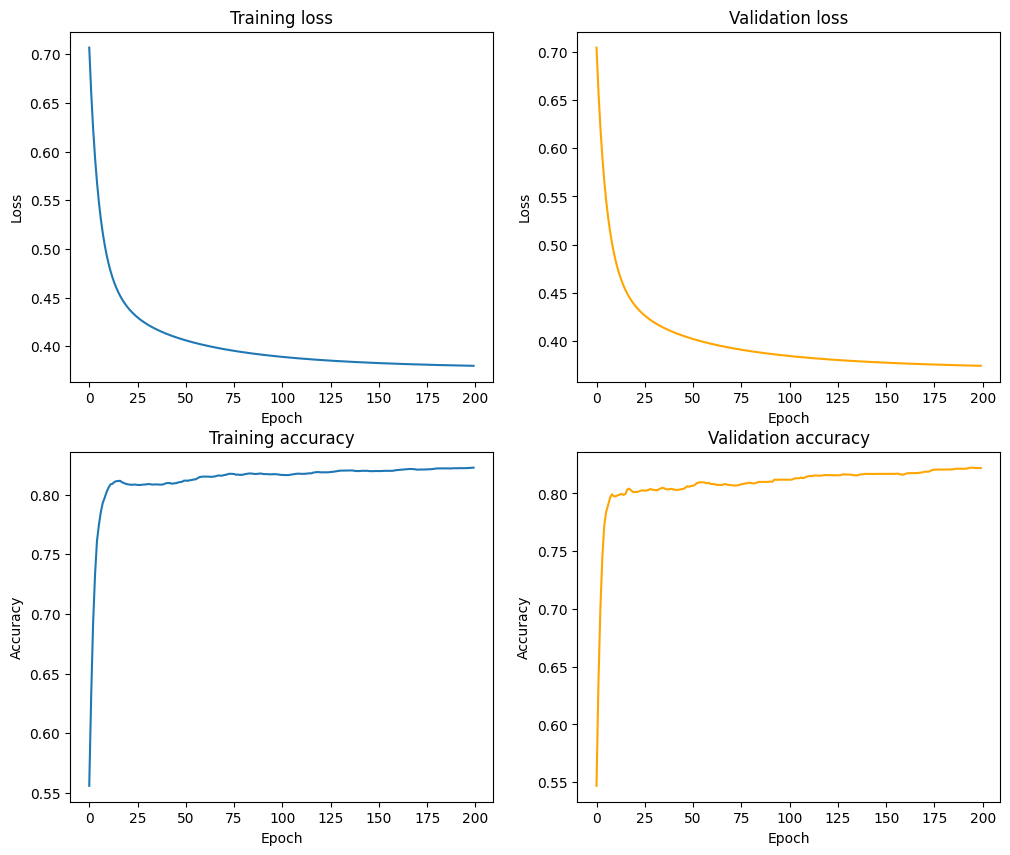

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation accuracy')

plt.show()

## Evaluate model

In [24]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

print ('Evaluation on validation and test set:')
print (f'Accuracy: {val_set_acc}')
print (f'Accuracy: {test_set_acc}')

Evaluation on validation and test set:
Accuracy: 0.821969696969697
Accuracy: 0.8434343434343434
